# Imports

In [1]:
from math import ceil
import json
import os
import sys

src_path = os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(src_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import visdom

from datasets import link_prediction
from layers import MeanAggregator, LSTMAggregator, MaxPoolAggregator, MeanPoolAggregator
import models
import utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Set up arguments for datasets, models and training.

In [2]:
args = {
    "task" : "link_prediction",
    
    "dataset" : "IAContactsHypertext",
    "dataset_path" : "/Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-contacts_hypertext2009/ia-contacts_hypertext2009.edges",
    "mode" : "train",
    "generate_neg_examples" : False,
    
    "duplicate_examples" : True,
    "repeat_examples" : True,
    
    "self_loop" : True,
    "normalize_adj" : False,
    
    "cuda" : True,
    "model" : "GAT",
    "num_heads" : [1, 1],
    "hidden_dims" : [64],
    "dropout" : 0,
    
    "epochs" : 3,
    "batch_size" : 32,
    "lr" : 5e-4,
    "weight_decay" : 5e-3,
    "stats_per_batch" : 3,
    "visdom" : True,
    
    "load" : False,
    "save" : False
}
config = args
config['num_layers'] = len(config['hidden_dims']) + 1


if config['cuda'] and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
config['device'] = device

# Get the dataset, dataloader and model.

In [3]:
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'train',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-contacts_hypertext2009/ia-contacts_hypertext2009.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: train
Number of vertices: 113
Number of static edges: 1010
Number of temporal edges: 6245
Number of examples/datapoints: 7886
--------------------------------


In [4]:
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=True, collate_fn=dataset.collate_wrapper)
input_dim, output_dim = dataset.get_dims()

In [5]:
model = models.GAT(input_dim, config['hidden_dims'],
                   output_dim, config['num_heads'],
                   config['dropout'], config['device'])
model.apply(models.init_weights)
model.to(config['device'])
print(model)

GAT(
  (attn): ModuleList(
    (0): GraphAttention(
      (fcs): ModuleList(
        (0): Linear(in_features=113, out_features=64, bias=True)
      )
      (a): ModuleList(
        (0): Linear(in_features=128, out_features=1, bias=True)
      )
      (dropout): Dropout(p=0)
      (softmax): Softmax()
      (leakyrelu): LeakyReLU(negative_slope=0.01)
    )
    (1): GraphAttention(
      (fcs): ModuleList(
        (0): Linear(in_features=64, out_features=1, bias=True)
      )
      (a): ModuleList(
        (0): Linear(in_features=2, out_features=1, bias=True)
      )
      (dropout): Dropout(p=0)
      (softmax): Softmax()
      (leakyrelu): LeakyReLU(negative_slope=0.01)
    )
  )
  (bns): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0)
  (elu): ELU(alpha=1.0)
)


# Compute ROC-AUC score for the untrained model.

In [6]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset before training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')

--------------------------------
Computing ROC-AUC score for the training dataset before training.
    Batch 1 / 247
    Batch 2 / 247
    Batch 3 / 247
    Batch 4 / 247
    Batch 5 / 247
    Batch 6 / 247
    Batch 7 / 247
    Batch 8 / 247
    Batch 9 / 247
    Batch 10 / 247
    Batch 11 / 247
    Batch 12 / 247
    Batch 13 / 247
    Batch 14 / 247
    Batch 15 / 247
    Batch 16 / 247
    Batch 17 / 247
    Batch 18 / 247
    Batch 19 / 247
    Batch 20 / 247
    Batch 21 / 247
    Batch 22 / 247
    Batch 23 / 247
    Batch 24 / 247
    Batch 25 / 247
    Batch 26 / 247
    Batch 27 / 247
    Batch 28 / 247
    Batch 29 / 247
    Batch 30 / 247
    Batch 31 / 247
    Batch 32 / 247
    Batch 33 / 247
    Batch 34 / 247
    Batch 35 / 247
    Batch 36 / 247
    Batch 37 / 247
    Batch 38 / 247
    Batch 39 / 247
    Batch 40 / 247
    Batch 41 / 247
    Batch 42 / 247
    Batch 43 / 247
    Batch 44 / 247
    Batch 45 / 247
    Batch 46 / 247
    Batch 47 / 247
    Batch 48 / 24

# Train.

In [7]:
if not config['load']:
    use_visdom = config['visdom']
    if use_visdom:
        vis = visdom.Visdom()
        loss_window = None
    criterion = utils.get_criterion(config['task'])
    optimizer = optim.Adam(model.parameters(), lr=config['lr'],
                           weight_decay=config['weight_decay'])
    epochs = config['epochs']
    stats_per_batch = config['stats_per_batch']
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200], gamma=0.5)
    model.train()
    print('--------------------------------')
    print('Training.')
    for epoch in range(epochs):
        print('Epoch {} / {}'.format(epoch+1, epochs))
        running_loss = 0.0
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            loss = criterion(scores, labels.float())
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item()
            if (idx + 1) % stats_per_batch == 0:
                running_loss /= stats_per_batch
                print('    Batch {} / {}: loss {:.4f}'.format(
                    idx+1, num_batches, running_loss))
                if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
                    area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
                    print('    ROC-AUC score: {:.4f}'.format(area))
                running_loss = 0.0
                num_correct, num_examples = 0, 0
            if use_visdom:
                if loss_window is None:
                    loss_window = vis.line(
                        Y=[loss.item()],
                        X=[epoch*num_batches+idx],
                        opts=dict(xlabel='batch', ylabel='Loss', title='Training Loss', legend=['Loss']))
                else:
                    vis.line(
                        [loss.item()],
                        [epoch*num_batches+idx],
                        win=loss_window,
                        update='append')
            scheduler.step()
    if use_visdom:
        vis.close(win=loss_window)
    print('Finished training.')
    print('--------------------------------')

--------------------------------
Training.
Epoch 1 / 3
    Batch 3 / 247: loss 0.9873
    ROC-AUC score: 0.3961
    Batch 6 / 247: loss 0.8091
    ROC-AUC score: 0.7176
    Batch 9 / 247: loss 0.8724
    ROC-AUC score: 0.5059
    Batch 12 / 247: loss 0.7415
    ROC-AUC score: 0.4841
    Batch 15 / 247: loss 0.7847
    ROC-AUC score: 0.4980
    Batch 18 / 247: loss 0.7850
    ROC-AUC score: 0.4702
    Batch 21 / 247: loss 0.7221
    ROC-AUC score: 0.3441
    Batch 24 / 247: loss 0.8215
    ROC-AUC score: 0.5686
    Batch 27 / 247: loss 0.6875
    ROC-AUC score: 0.5833
    Batch 30 / 247: loss 0.7625
    ROC-AUC score: 0.6397
    Batch 33 / 247: loss 0.7719
    ROC-AUC score: 0.6587
    Batch 36 / 247: loss 0.7002
    ROC-AUC score: 0.6875
    Batch 39 / 247: loss 0.6731
    ROC-AUC score: 0.4042
    Batch 42 / 247: loss 0.7042
    ROC-AUC score: 0.6599
    Batch 45 / 247: loss 0.7236
    ROC-AUC score: 0.7961
    Batch 48 / 247: loss 0.9591
    ROC-AUC score: 0.4008
    Batch 51 / 247: 

    Batch 174 / 247: loss 0.6370
    ROC-AUC score: 0.6902
    Batch 177 / 247: loss 0.6329
    ROC-AUC score: 0.8320
    Batch 180 / 247: loss 0.6846
    ROC-AUC score: 0.6270
    Batch 183 / 247: loss 0.6305
    ROC-AUC score: 0.7216
    Batch 186 / 247: loss 0.6614
    ROC-AUC score: 0.7852
    Batch 189 / 247: loss 0.5969
    ROC-AUC score: 0.8138
    Batch 192 / 247: loss 0.6276
    ROC-AUC score: 0.6349
    Batch 195 / 247: loss 0.6156
    ROC-AUC score: 0.8016
    Batch 198 / 247: loss 0.6582
    ROC-AUC score: 0.6039
    Batch 201 / 247: loss 0.6183
    ROC-AUC score: 0.7183
    Batch 204 / 247: loss 0.7445
    ROC-AUC score: 0.5859
    Batch 207 / 247: loss 0.6393
    ROC-AUC score: 0.5668
    Batch 210 / 247: loss 0.6908
    ROC-AUC score: 0.7341
    Batch 213 / 247: loss 0.6715
    ROC-AUC score: 0.7647
    Batch 216 / 247: loss 0.6257
    ROC-AUC score: 0.7652
    Batch 219 / 247: loss 0.6889
    ROC-AUC score: 0.5397
    Batch 222 / 247: loss 0.6695
    ROC-AUC score: 0.74

In [8]:
if not config['load']:
    if config['save']:
        print('--------------------------------')
        directory = os.path.join(os.path.dirname(os.getcwd()),
                                'trained_models')
        if not os.path.exists(directory):
            os.makedirs(directory)
        fname = utils.get_fname(config)
        path = os.path.join(directory, fname)
        print('Saving model at {}'.format(path))
        torch.save(model.state_dict(), path)
        print('Finished saving model.')
        print('--------------------------------')

# Compute ROC-AUC score after training.

In [9]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset after training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')


--------------------------------
Computing ROC-AUC score for the training dataset after training.
    Batch 1 / 247
    Batch 2 / 247
    Batch 3 / 247
    Batch 4 / 247
    Batch 5 / 247
    Batch 6 / 247
    Batch 7 / 247
    Batch 8 / 247
    Batch 9 / 247
    Batch 10 / 247
    Batch 11 / 247
    Batch 12 / 247
    Batch 13 / 247
    Batch 14 / 247
    Batch 15 / 247
    Batch 16 / 247
    Batch 17 / 247
    Batch 18 / 247
    Batch 19 / 247
    Batch 20 / 247
    Batch 21 / 247
    Batch 22 / 247
    Batch 23 / 247
    Batch 24 / 247
    Batch 25 / 247
    Batch 26 / 247
    Batch 27 / 247
    Batch 28 / 247
    Batch 29 / 247
    Batch 30 / 247
    Batch 31 / 247
    Batch 32 / 247
    Batch 33 / 247
    Batch 34 / 247
    Batch 35 / 247
    Batch 36 / 247
    Batch 37 / 247
    Batch 38 / 247
    Batch 39 / 247
    Batch 40 / 247
    Batch 41 / 247
    Batch 42 / 247
    Batch 43 / 247
    Batch 44 / 247
    Batch 45 / 247
    Batch 46 / 247
    Batch 47 / 247
    Batch 48 / 247

# Plot the true positive rate and true negative rate vs threshold.

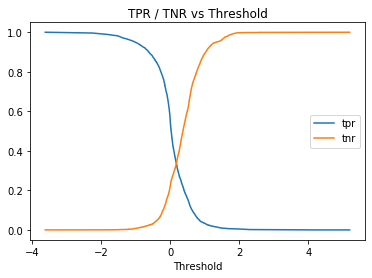

In [10]:
if not config['load']:
    tpr, fpr, thresholds = roc_curve(y_true, y_scores)
    tnr = 1 - fpr
    plt.plot(thresholds, tpr, label='tpr')
    plt.plot(thresholds, tnr, label='tnr')
    plt.xlabel('Threshold')
    plt.title('TPR / TNR vs Threshold')
    plt.legend()

# Choose an appropriate threshold and generate classification report on the train set.

In [11]:
idx1 = np.where(tpr <= tnr)[0]
idx2 = np.where(tpr >= tnr)[0]
t = thresholds[idx1[-1]]
total_correct, total_examples = 0, 0
y_true, y_pred = [], []
num_batches = int(ceil(len(dataset) / config['batch_size']))
with torch.no_grad():
    for (idx, batch) in enumerate(loader):
        edges, features, node_layers, mappings, rows, labels = batch
        features, labels = features.to(device), labels.to(device)
        out = model(features, node_layers, mappings, rows)
        all_pairs = torch.mm(out, out.t())
        scores = all_pairs[edges.T]
        predictions = (scores >= t).long()
        y_true.extend(labels.detach().numpy())
        y_pred.extend(predictions.detach().numpy())
        total_correct += torch.sum(predictions == labels.long()).item()
        total_examples += len(labels) 
        print('    Batch {} / {}'.format(idx+1, num_batches))
print('Threshold: {:.4f}, accuracy: {:.4f}'.format(t, total_correct / total_examples))
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
print('Classification report\n', report)

    Batch 1 / 247
    Batch 2 / 247
    Batch 3 / 247
    Batch 4 / 247
    Batch 5 / 247
    Batch 6 / 247
    Batch 7 / 247
    Batch 8 / 247
    Batch 9 / 247
    Batch 10 / 247
    Batch 11 / 247
    Batch 12 / 247
    Batch 13 / 247
    Batch 14 / 247
    Batch 15 / 247
    Batch 16 / 247
    Batch 17 / 247
    Batch 18 / 247
    Batch 19 / 247
    Batch 20 / 247
    Batch 21 / 247
    Batch 22 / 247
    Batch 23 / 247
    Batch 24 / 247
    Batch 25 / 247
    Batch 26 / 247
    Batch 27 / 247
    Batch 28 / 247
    Batch 29 / 247
    Batch 30 / 247
    Batch 31 / 247
    Batch 32 / 247
    Batch 33 / 247
    Batch 34 / 247
    Batch 35 / 247
    Batch 36 / 247
    Batch 37 / 247
    Batch 38 / 247
    Batch 39 / 247
    Batch 40 / 247
    Batch 41 / 247
    Batch 42 / 247
    Batch 43 / 247
    Batch 44 / 247
    Batch 45 / 247
    Batch 46 / 247
    Batch 47 / 247
    Batch 48 / 247
    Batch 49 / 247
    Batch 50 / 247
    Batch 51 / 247
    Batch 52 / 247
    Batch 53 / 247
  

# Evaluate on validation set.

In [25]:
if config['load']:
    directory = os.path.join(os.path.dirname(os.getcwd()),
                             'trained_models')
    fname = utils.get_fname(config)
    path = os.path.join(directory, fname)
    model.load_state_dict(torch.load(path))
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'val',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=False, collate_fn=dataset.collate_wrapper)
criterion = utils.get_criterion(config['task'])
stats_per_batch = config['stats_per_batch']
num_batches = int(ceil(len(dataset) / config['batch_size']))
model.eval()
print('--------------------------------')
print('Computing ROC-AUC score for the validation dataset after training.')
running_loss, total_loss = 0.0, 0.0
num_correct, num_examples = 0, 0
total_correct, total_examples = 0, 0
y_true, y_scores, y_pred = [], [], []
for (idx, batch) in enumerate(loader):
    edges, features, node_layers, mappings, rows, labels = batch
    features, labels = features.to(device), labels.to(device)
    out = model(features, node_layers, mappings, rows)
    all_pairs = torch.mm(out, out.t())
    scores = all_pairs[edges.T]
    loss = criterion(scores, labels.float())
    running_loss += loss.item()
    total_loss += loss.item()
    predictions = (scores >= t).long()
    num_correct += torch.sum(predictions == labels.long()).item()
    total_correct += torch.sum(predictions == labels.long()).item()
    num_examples += len(labels)
    total_examples += len(labels)
    y_true.extend(labels.detach().numpy())
    y_scores.extend(scores.detach().numpy())
    y_pred.extend(predictions.detach().numpy())
    if (idx + 1) % stats_per_batch == 0:
        running_loss /= stats_per_batch
        accuracy = num_correct / num_examples
        print('    Batch {} / {}: loss {:.4f}, accuracy {:.4f}'.format(
            idx+1, num_batches, running_loss, accuracy))
        if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
            area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
            print('    ROC-AUC score: {:.4f}'.format(area))
        running_loss = 0.0
        num_correct, num_examples = 0, 0
total_loss /= num_batches
total_accuracy = total_correct / total_examples
print('Loss {:.4f}, accuracy {:.4f}'.format(total_loss, total_accuracy))
y_true = np.array(y_true).flatten()
y_scores = np.array(y_scores).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
area = roc_auc_score(y_true, y_scores)
print('ROC-AUC score: {:.4f}'.format(area))
print('Classification report\n', report)
print('Finished validating.')
print('--------------------------------')

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-contact/ia-contact.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: val
Number of vertices: 274
Number of static edges: 2112
Number of temporal edges: 14122
Number of examples/datapoints: 14122
--------------------------------
--------------------------------
Computing ROC-AUC score for the validation dataset after training.
    Batch 3 / 442: loss 0.4659, accuracy 0.7917
    ROC-AUC score: 0.8353
    Batch 6 / 442: loss 0.3777, accuracy 0.8958
    ROC-AUC score: 1.0000
    Batch 9 / 442: loss 0.5202, accuracy 0.8229
    ROC-AUC score: 0.9365
    Batch 12 / 442: loss 0.5451, accuracy 0.8542
    ROC-AUC score: 0.8219
    Batch 15 / 442: loss 0.5577, accuracy 0.8542
    ROC-AUC score: 0.8849
    Batch 18 / 442: loss 0.4859, accuracy 0.7708
    ROC-AUC score: 0.92

    Batch 306 / 442: loss 0.4435, accuracy 0.8542
    ROC-AUC score: 0.9804
    Batch 309 / 442: loss 0.4709, accuracy 0.8125
    ROC-AUC score: 0.9762
    Batch 312 / 442: loss 0.3869, accuracy 0.8229
    ROC-AUC score: 0.8958
    Batch 315 / 442: loss 0.5191, accuracy 0.8750
    ROC-AUC score: 0.8696
    Batch 318 / 442: loss 0.4682, accuracy 0.8333
    ROC-AUC score: 0.9492
    Batch 321 / 442: loss 0.4777, accuracy 0.8333
    ROC-AUC score: 0.9286
    Batch 324 / 442: loss 0.4501, accuracy 0.8646
    ROC-AUC score: 0.8958
    Batch 327 / 442: loss 0.4264, accuracy 0.8542
    ROC-AUC score: 0.9570
    Batch 330 / 442: loss 0.4752, accuracy 0.8125
    ROC-AUC score: 0.9333
    Batch 333 / 442: loss 0.4282, accuracy 0.7917
    ROC-AUC score: 0.8528
    Batch 336 / 442: loss 0.4193, accuracy 0.8646
    ROC-AUC score: 0.9603
    Batch 339 / 442: loss 0.4173, accuracy 0.8646
    ROC-AUC score: 1.0000
    Batch 342 / 442: loss 0.4087, accuracy 0.8542
    ROC-AUC score: 0.9569
    Batch 34

# Evaluate on test set.

In [ ]:
if config['load']:
    directory = os.path.join(os.path.dirname(os.getcwd()),
                             'trained_models')
    fname = utils.get_fname(config)
    path = os.path.join(directory, fname)
    model.load_state_dict(torch.load(path))
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'test',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=False, collate_fn=dataset.collate_wrapper)
criterion = utils.get_criterion(config['task'])
stats_per_batch = config['stats_per_batch']
num_batches = int(ceil(len(dataset) / config['batch_size']))
model.eval()
print('--------------------------------')
print('Computing ROC-AUC score for the test dataset after training.')
running_loss, total_loss = 0.0, 0.0
num_correct, num_examples = 0, 0
total_correct, total_examples = 0, 0
y_true, y_scores, y_pred = [], [], []
for (idx, batch) in enumerate(loader):
    edges, features, node_layers, mappings, rows, labels = batch
    features, labels = features.to(device), labels.to(device)
    out = model(features, node_layers, mappings, rows)
    all_pairs = torch.mm(out, out.t())
    scores = all_pairs[edges.T]
    loss = criterion(scores, labels.float())
    running_loss += loss.item()
    total_loss += loss.item()
    predictions = (scores >= t).long()
    num_correct += torch.sum(predictions == labels.long()).item()
    total_correct += torch.sum(predictions == labels.long()).item()
    num_examples += len(labels)
    total_examples += len(labels)
    y_true.extend(labels.detach().numpy())
    y_scores.extend(scores.detach().numpy())
    y_pred.extend(predictions.detach().numpy())
    if (idx + 1) % stats_per_batch == 0:
        running_loss /= stats_per_batch
        accuracy = num_correct / num_examples
        print('    Batch {} / {}: loss {:.4f}, accuracy {:.4f}'.format(
            idx+1, num_batches, running_loss, accuracy))
        if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
            area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
            print('    ROC-AUC score: {:.4f}'.format(area))
        running_loss = 0.0
        num_correct, num_examples = 0, 0
total_loss /= num_batches
total_accuracy = total_correct / total_examples
print('Loss {:.4f}, accuracy {:.4f}'.format(total_loss, total_accuracy))
y_true = np.array(y_true).flatten()
y_scores = np.array(y_scores).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
area = roc_auc_score(y_true, y_scores)
print('ROC-AUC score: {:.4f}'.format(area))
print('Classification report\n', report)
print('Finished testing.')
print('--------------------------------')

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-contact/ia-contact.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: test
Number of vertices: 274
Number of static edges: 2472
Number of temporal edges: 21183
Number of examples/datapoints: 14100
--------------------------------
--------------------------------
Computing ROC-AUC score for the test dataset after training.
    Batch 3 / 441: loss 0.4724, accuracy 0.7292
    ROC-AUC score: 0.8955
    Batch 6 / 441: loss 0.4283, accuracy 0.7188
    ROC-AUC score: 0.9960
    Batch 9 / 441: loss 0.4950, accuracy 0.7604
    ROC-AUC score: 0.8929
    Batch 12 / 441: loss 0.5190, accuracy 0.8125
    ROC-AUC score: 0.9127
    Batch 15 / 441: loss 0.4771, accuracy 0.7292
    ROC-AUC score: 0.8471
    Batch 18 / 441: loss 0.4853, accuracy 0.6562
    ROC-AUC score: 0.9167
  